In [1]:
# ---------------------------------------------------------------

# ----------------- results specific framework

# ---------------------------------------------------------------


# ¡¡¡ --- !!! # ---> modules and data cases

# --- system modules

import sys
import datetime
import os


base_dir = os.path.abspath(os.getcwd() + "/..")

# --- data handling modules

import numpy as np
import pandas as pd
import scipy.io as sp_io
import scipy as sp

# --- visualization modules

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- my modules

methods_dir = base_dir + '/methods/'  
sys.path.insert(0, methods_dir)
from class_sample_selection import sample_selection
import simpls_module



# ¡¡¡ --- !!! # ---> base working directory and available data cases

# # ************************************ init --- user 
caseID_key = "d02_manure"
y_id = 1 # DM
# # ************************************ end --- user 



# # ¡¡¡ --- !!! # ---> data

mat_filename = base_dir + "/data/" + caseID_key +".mat"
data_mat = sp_io.loadmat(mat_filename, struct_as_record = False)



x_all = data_mat["xcal"].copy()
# ycal = data_mat["ycal"].copy()[:,[y_id]]
# xtest = data_mat["xtest"].copy()
# ytest = data_mat["ytest"].copy()[:,[y_id]]
# chemical_comp_name = data_mat["y_labels"][y_id]


# test_groups = np.ones(xtest.shape[0]).astype(int)

print(x_all.shape)

print("--- data ready ---")







(420, 141)
--- data ready ---


In [3]:
# --- svd full sample


X_c = x_all - x_all.mean(axis=0)
X_c_t = np.ascontiguousarray(X_c.transpose())
cov_X = X_c_t.dot(X_c)/X_c.shape[0]

svd_cov_X = np.linalg.svd(cov_X)

In [4]:
# --- eigenvalues


# *******************
n_sel_range = np.arange(30, 400, 10)
dim_red = True
dist_measure ='mahalanobis'
chosen_rank = 20
# *******************



my_sample_selection = sample_selection(x_all, ncp = chosen_rank)
my_sample_selection.get_xcal_pca_scores()


eigen_vals_ratio = np.zeros((n_sel_range.shape[0], chosen_rank, 6))
eigen_vect_comparison = np.zeros((chosen_rank, chosen_rank,n_sel_range.shape[0], 6))

ii = 0
for n_sel in n_sel_range:
    
    samples_dict = dict()

    samples_dict['ks'] = my_sample_selection.kennard_stone(Nout = n_sel, fixed_samples=None, dim_reduction=dim_red, distance_measure=dist_measure)['sample_id'][:,0]
    samples_dict['duplex'] = my_sample_selection.duplex(Nout = n_sel, dim_reduction=dim_red, distance_measure=dist_measure)['sample_id'][:,0]
    samples_dict['puchwein'] = my_sample_selection.puchwein(Nout = n_sel, factor_k=0.0001, dim_reduction=dim_red, distance_measure=dist_measure)['sample_id'][:,0]
    samples_dict['clustering'] = my_sample_selection.clustering(Nout = n_sel, dim_reduction=dim_red, distance_measure=dist_measure)['sample_id'][:,0]
    samples_dict['optfederov'] = my_sample_selection.optfederov_r(Nout = n_sel, fixed_samples=None, optimality_criterion='D')['sample_id'][:,0]
    samples_dict['random'] = my_sample_selection.random_sample(Nout = n_sel)['sample_id'][:,0]

    jj = 0
    
    for method in ['ks', 'duplex', 'puchwein', 'clustering', 'optfederov', 'random']:
        
        current_samples = samples_dict[method].copy()

        x_selected = x_all[current_samples==1,:]
        Xs_c = x_selected - x_selected.mean(axis=0)
        Xs_c_t = np.ascontiguousarray(Xs_c.transpose())
        cov_Xs = Xs_c_t.dot(Xs_c)/Xs_c.shape[0]
        svd_selected = np.linalg.svd(cov_Xs)

        eigen_vals_ratio[ii,:,jj] = svd_selected[1][0:chosen_rank]/svd_cov_X[1][0:chosen_rank]
        eigen_vect_comparison[:,:,ii,jj] = svd_selected[0][:,0:chosen_rank].T.dot(svd_cov_X[0][:,0:chosen_rank])
        
        jj+=1
        
    ii+=1

print("done")

done


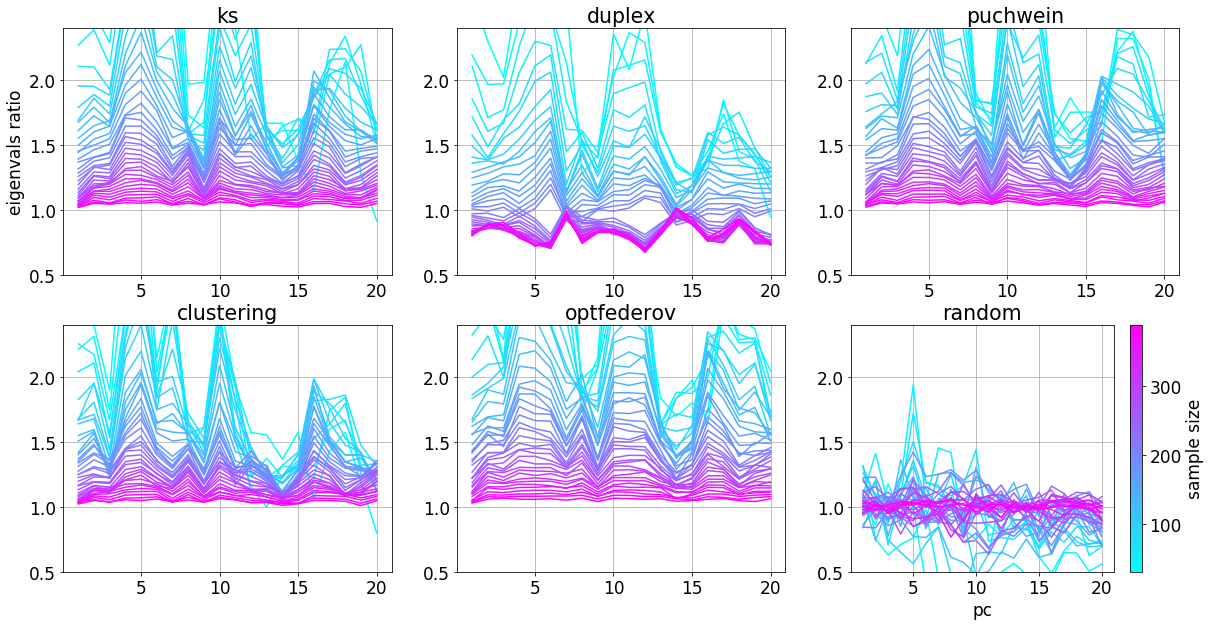

In [5]:
# --- plot eigenvals ratio color mapping

import matplotlib as mtply

color_var = np.array(n_sel_range)
min_color_var = np.amin(color_var)
max_color_var = np.amax(color_var)

c_m = mtply.cm.cool
norm = mtply.colors.Normalize(vmin = min_color_var, vmax = max_color_var)
s_m = mtply.cm.ScalarMappable(cmap = c_m, norm = norm)

methods_list = ['ks', 'duplex', 'puchwein', 'clustering', 'optfederov', 'random']

plt.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (20,10))


jj = 0
for method in methods_list: 
    
    jj2 = jj
    
    if jj<3:
        k1=0
    else:
        k1=1
    
    if k1==1:
        jj2=jj-3

    for ii in range(eigen_vals_ratio.shape[0]):
        color_tuple = s_m.to_rgba(n_sel_range[ii])
        ax[k1,jj2].plot(np.arange(1,chosen_rank+1),eigen_vals_ratio[ii,:,jj], c = color_tuple)
    ax[k1,jj2].grid()
    ax[k1,jj2].set_title(method)
    ax[k1,jj2].set_ylim([0.5,2.4])
     
    jj+=1
    
ax[-1,-1].set_xlabel("pc")
ax[0,0].set_ylabel("eigenvals ratio")
cm = plt.colorbar(s_m)
cm.set_label("sample size")
plt.savefig(base_dir + "/manuscript/figures/"+caseID_key+"_specific_framework_eigenvalsratio.png",bbox_inches="tight")
plt.show()


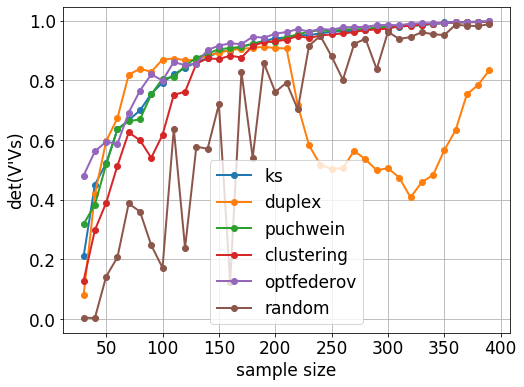

In [6]:
# --- plot eigenvect comparison determinant

determinants = np.zeros(eigen_vect_comparison.shape[2:4])

jj = 0 
for method in ['ks', 'duplex', 'puchwein', 'clustering', 'optfederov', 'random']:
 

    for ss_ii in range(eigen_vect_comparison.shape[2]):
        
        determinants[ss_ii,jj] = np.abs(np.linalg.det(eigen_vect_comparison[:,:,ss_ii,jj]))
        
 
    jj += 1



plt.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(figsize = (8,6))
plt.plot(n_sel_range,determinants,'o-',linewidth=2)
plt.legend(['ks', 'duplex', 'puchwein', 'clustering', 'optfederov', 'random'])
plt.xlabel("sample size")
plt.ylabel("det(V'Vs)")
plt.grid()
plt.savefig(base_dir + "/manuscript/figures/"+caseID_key+"_specific_framework_detereigevect.png",bbox_inches="tight")
plt.show()


